# Исследование новой механики оплат в онлайн - школе.

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных 4 csv-файла:

- **groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- **groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- **checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from urllib.parse import urlencode
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import chi2_contingency, chi2 
plt.style.use('ggplot')


In [2]:
# Считываем входные данные
groups = pd.read_csv('/Users/user/Проект_2_groups.csv')
groups_add = pd.read_csv('/Users/user/Проект_2_group_add.csv')
active_studs = pd.read_csv('/Users/user/Проект_2_active_studs.csv')
checks = pd.read_csv('/Users/user/Проект_2_checks.csv')

## Предобработка данных

Обзор данных

In [3]:
display(groups.head())
groups.shape

,id;grp
0,1489;B
1,1627;A
2,1768;B
3,1783;B
4,1794;A


(74484, 1)

In [4]:
display(groups_add.head())
groups_add.shape

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


(92, 2)

In [5]:
display(active_studs.head())
active_studs.shape

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


(8341, 1)

In [6]:
display(checks.head())
checks.shape

,"student_id;""rev"""
0,1627;990.0
1,3185;690.0
2,25973;690.0
3,26280;690.0
4,100300;990.0


(541, 1)

Приводим колонки всех таблиц к единым названиям.
Переименовываем колонки в таблице `groups` на `user_id` и добавляем новую - `group_name`.В колонку `group_name` добавляем данные из колонки `user_id` - название группы. Т.к. данные в колонке `user_id` типа `object` - приводим данные колонки 
к типу `int`.

In [7]:
groups = groups.rename(columns={'id;grp':'user_id'})
groups['group_name'] = groups.user_id.apply(lambda x: x.split(';')[-1])
groups['user_id'] = groups.user_id.apply(lambda x: x.split(';')[0])
groups = groups.astype({'user_id': 'int'})

In [8]:
# Переименовываем колонки в таблице groups_add. 

groups_add = groups_add.rename(columns={'id':'user_id', 'grp':'group_name'})

In [9]:
# Переименовываем колонку в таблице active_studs


active_studs = active_studs.rename(columns={'student_id':'user_id'})

In [10]:
# В таблице checks меняем название колонки student_id;"rev" на user_id и добаляем новую колонку payment. В колонку
# payment добавляем данные из колонки user_id - размеры оплат. Т.к. изначально данные колонок типа object, приводим 
# их к типу int и float

checks = checks.rename(columns={'student_id;"rev"':'user_id'})
checks['payment'] = checks.user_id.apply(lambda x: x.split(';')[-1])
checks['user_id'] = checks.user_id.apply(lambda x: x.split(';')[0])
checks = checks.astype({'user_id': 'int', 'payment': 'float'})

In [11]:
# Конкатируем таблицы groups и groups_add для получения итоговой таблицы пользователей, поделенных на группы
# для эксперимента и записываем общую таблицу под названием all_groups

all_groups = pd.concat([groups, groups_add], ignore_index=True)
all_groups

,user_id,group_name
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [12]:
all_groups.nunique()

user_id       74576
group_name        2
dtype: int64

In [13]:
# Проверим наличие пропусков в all_groups

all_groups.isna().sum()

user_id       0
group_name    0
dtype: int64

In [14]:
# Объединяем таблицы active_studs и checks в одну active_and_paid для получения таблицы о пользователях зашедших 
# на платформу в дни проведения эксперимента и о пользователях, произведших оплату 

active_and_paid = active_studs.merge(checks, how = 'left', on = 'user_id')
active_and_paid

,user_id,payment
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


In [15]:
active_and_paid.nunique()

user_id    8341
payment      38
dtype: int64

In [16]:
# Проверим наличие пропусков в active_and_paid

active_and_paid.isna().sum()

user_id       0
payment    7949
dtype: int64

Объединяем две таблицы `all_groups` и `active_and_paid` в итоговую по пользователям для проведения А/В теста. Объединяем по `user_id` в таблице `active_and_paid`, т.к. в ней есть необходимая нам информация по активным пользователям в дни проведения эксперимента. 
В итоге получаем таблицу с информацией по активным пользователям: кто из них  произвел оплату, а кто нет. Пропущенные 
значения заменяем нулем, т.к. имеются пользователи, которые заходили на сайт, но оплату не произвели.

In [17]:
total_frame = all_groups.merge(active_and_paid, how = 'right', on ='user_id')
total_frame = total_frame.fillna(0)
total_frame

,user_id,group_name,payment
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0
...,...,...,...
8336,1794344,B,0.0
8337,296883,B,0.0
8338,3598448,B,0.0
8339,3610547,B,290.0


In [18]:
# Проверим уникальность пользователей. Судя по значениям - задвоений в пользователях нет

total_frame.nunique()

user_id       8341
group_name       2
payment         39
dtype: int64

In [19]:
# Проверим наличие пропущенных значений в даннных. 
total_frame.isna().sum()

user_id       0
group_name    0
payment       0
dtype: int64

Исходя из имеющихся данных, посчитаю для анализа такие метрики как: `Конверсия(CR)`, `Средний доход на платящего пользователя(ARPPU)` и `Cредний доход с привлечённого пользователя(ARPU)`. Для подсчет метрик, необходимы данные по группам: по сумме оплат, по колличеству активных клиентов и по колличеству оплативших клиентов

In [20]:
revenue_groups = total_frame.groupby('group_name', as_index=False)\
                            .agg({'payment': 'sum'})\
                            .rename(columns={'payment': 'revenue'})\
                            .round(2)

active_users_groups = total_frame.groupby('group_name', as_index=False)\
                                 .agg({'user_id':'count'})\
                                 .rename(columns={'user_id': 'active_users'})

paying_users_groups = total_frame.query('payment > 0')\
                                 .groupby('group_name', as_index=False)\
                                 .agg({'user_id': 'count'})\
                                 .rename(columns={'user_id':'paying_users'})

In [21]:
revenue_groups

,group_name,revenue
0,A,72820.0
1,B,394974.0


In [22]:
active_users_groups

,group_name,active_users
0,A,1538
1,B,6803


In [23]:
paying_users_groups

,group_name,paying_users
0,A,78
1,B,314


In [24]:
# Объединим полученные данные

metrics = revenue_groups.merge(active_users_groups).merge(paying_users_groups)
metrics

,group_name,revenue,active_users,paying_users
0,A,72820.0,1538,78
1,B,394974.0,6803,314


Рассчитам метрики и добавим их в итоговую таблицу:

- CR(conversion rate) = (Paying Users / Active Users) * 100 (коэффициент платящих пользователей к активным)
- ARPPU (Average Revenue Per Paying User) = Revenue / Paying Users (средний доход на платящего пользователя)
- ARPU (Average revenue per user) = Revenue / Active Users (средний доход с активного пользователя)


In [25]:
metrics['CR'] = ((metrics.paying_users/metrics.active_users)*100).round(2)
metrics['ARPPU'] = (metrics.revenue/metrics.paying_users).round(2)
metrics['ARPU'] = (metrics.revenue/metrics.active_users).round(2)
metrics

,group_name,revenue,active_users,paying_users,CR,ARPPU,ARPU
0,A,72820.0,1538,78,5.07,933.59,47.35
1,B,394974.0,6803,314,4.62,1257.88,58.06


Судя по итоговой таблице, в тестовой группе увеличились такие показатели как ARPPU и ARPU. CR, в свою очередь, 
уменьшилась. Являются ли различия в группах статистически значимыми? Проверим это в статистическом анализе.

## Исследовательский анализ данных

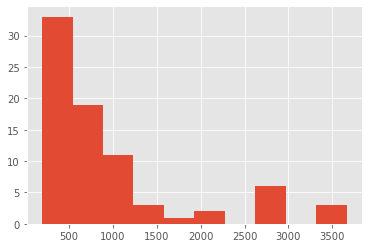

In [26]:
# Посмотрим распределения оплат по группам

group_A = total_frame.query('group_name == "A" and payment > 0')
group_A.payment.hist()
plt.show()

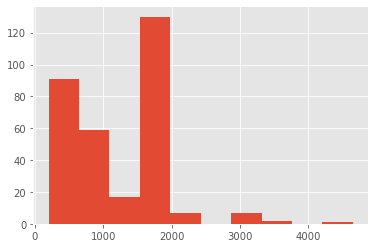

In [27]:
group_B = total_frame.query('group_name == "B" and payment > 0')
group_B.payment.hist()
plt.show()

Распределения отличаются от нормального. На графике распределения оплат по группе Б имеется подозрительный пик на оплате 1800 - 1900. Предполагаю, что тестовой группе, возможно, была предложена акция при оплате на данную сумму.

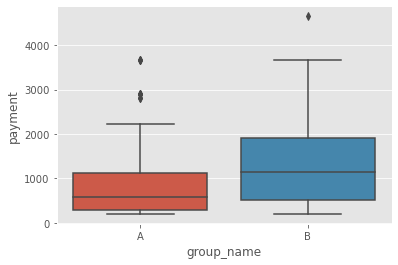

In [28]:
# Построим, также, график типа boxplot. Судя по графику - в оплатах есть выбросы.

sns.boxplot(x='group_name', y='payment', data = total_frame.query('payment > 0'))
plt.show()

In [29]:
# Проверим статистические данные по группам.

total_frame.query('payment > 0').pivot(index='user_id', columns='group_name', values='payment').describe()

group_name,A,B
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


## Статистический анализ получившихся результатов

В связи с тем, что распределения не нормальны и размеры групп отличаются - для теста выбираю метод Бутстрап.

Принимаем следующие гипотезы:

- H0 - разница в ARPU - статистически не значима

- H1 - разница в ARPU - статистически значима

In [30]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

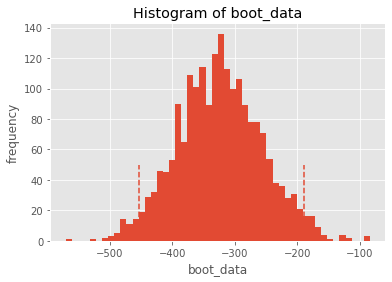

In [31]:
# применим функцию к оплатам по группам

booted_data = get_bootstrap(group_A.payment, group_B.payment , boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [32]:
booted_data["p_value"]

1.4529962278299634e-06

In [33]:
booted_data["ci"] #доверительные интервалы

,0
0.025,-453.982418
0.975,-189.365853


Т.к. p_value по результатам получился меньше 0 - отклоняем нулевую гипотезу. Из данного теста следует - что увеличение показателя ARPU статистически значимо.

Проверим, статистически ли значима разница показателя конверсии в группах с помощью критирерия хи - квадрат, т.к. данные категориальные.

Принимаем следующие гипотезы:

- H0 - взаимосвязи между группой и покупками - нет

- H1 - взаимосвязь между группой и покупками - есть

In [34]:
# Добавляю столбец status: 1-есть оплата, 0-нет оплаты.

total_frame['status'] = total_frame.payment.apply(lambda x: 1 if x>0 else 0)
total_frame_chi = pd.crosstab(total_frame.group_name, total_frame.status)
total_frame_chi

status,0,1
group_name,,
A,1460,78
B,6489,314


In [35]:
stat, p, dof, expected = chi2_contingency(total_frame_chi)
stat, p

(0.48480826522557896, 0.48625240457231045)

In [36]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


P-value > 0.05. Следовательно, взаимосвязи между группой и покупками - нет

# Вывод


Проанализировав исходные данные и 2 метрики, можно сделать следующий вывод: 

- Снижение конверсии в тестовой групее - не является следствием запуска теста и не является статистически значимым критерием;
- Изменение метрики ARPU является статистически значимым. Следовательно, запуск новой механики оплаты повлиял на увеличение среднего дохода с активного пользователя;
- Следует дополнительно запросить и проанализировать данные по оплатам из тестовой группы. Подозрительно частая оплата в районе 1800-1900 указывает на то, что возможно была запущена какая-либо акция при оплате услуги по данной стоимости, что могло повлиять на чистоту эксперимента, и сответственно, на полученный результат.

Перед выкатом нового механизма оплаты следует проверить идентичность условий в группах, исключить влияние сторонних факторов и повторить эксперимент.